In [43]:
import networkx as nx
import matplotlib.pyplot as plt

In [44]:
import matplotlib.cm as cm  # Para usar una paleta de colores continua
from networkx.drawing.nx_agraph import graphviz_layout

def mostrar_grafo(G):
    plt.figure(figsize=(10,10))  
    # Obtener todos los valores de profundidad para ajustar el rango de colores
    profundidades = [G.nodes[node].get('profundidad', 0) for node in G.nodes]
    
    # Normalizar las profundidades para asignar colores continuos en una escala
    min_prof, max_prof = min(profundidades), max(profundidades)
    colors = [
        cm.viridis((prof - min_prof) / (max_prof - min_prof)) if max_prof > min_prof else cm.viridis(0.5)
        for prof in profundidades
    ]
    
    nx.draw(G,with_labels=False, node_color=colors, edge_color="gray", node_size=2000, font_size=10)
    # Prepara las etiquetas con atributos de cada nodo
    labels = {node: f"n:{node}\np:{G.nodes[node].get('profundidad', '')}" for node in G.nodes}
    
    # Dibuja las etiquetas de los nodos con sus atributos
    nx.draw_networkx_labels(G, labels, font_size=15, font_color="white")
    
    plt.margins(0.2)
    plt.show()

In [45]:
def describir_arbol(G):
    def describir_arbol_aux(nodo, G, profundidad):
        hijos = list(G.successors(nodo))
        resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
        if hijos != []:
            for hijo in hijos:
                resultado+=describir_arbol_aux(hijo,G,profundidad+1)
        return resultado
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)

In [53]:
def hojas_preorden(G):
    return [
        nodo for nodo in nx.dfs_preorder_nodes(G, source=1)
        if G.out_degree(nodo) == 0
    ]


#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [47]:
import random
import networkx as nx

def formar_particion_estado_4(n, d=5, semilla=None):
    # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
    if semilla is not None:
        random.seed(semilla)
    else:
        # Generar una seed aleatoria y almacenarla
        semilla = random.randint(0, 2**32 - 1)
        random.seed(semilla)  # Establecer la seed
    
    lista_hojas = {1}  # Usamos un set para mejor eficiencia
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    nodos = 1
    
    for _ in range(n):
        if lista_hojas:
            selec = random.choice(tuple(lista_hojas))  # Convertir a tupla para elección aleatoria rápida
            profundidad_hijos = A.nodes[selec]["profundidad"] + 1
            
            if profundidad_hijos > A.graph['altura']:
                A.graph['altura'] = profundidad_hijos
            
            # Agregar los nuevos nodos
            for j in range(1, 5):
                nuevo_nodo = nodos + j
                A.add_node(nuevo_nodo, profundidad=profundidad_hijos)
                A.add_edge(selec, nuevo_nodo)
                if profundidad_hijos < d:
                    lista_hojas.add(nuevo_nodo)
            
            lista_hojas.remove(selec)  # El nodo ya no es hoja
            nodos += 4  # Se añaden 4 nodos en cada iteración
        else:
            break
            
    return A, semilla


In [58]:
import matplotlib.patches as patches
import os

class Cuadrado():
    def __init__(self, G, nodo=1, centro=None, tamaño=10, semilla = None):
        
        self.semilla = semilla if semilla is not None else random.randint(0, 2**32 - 1)
        random.seed(self.semilla)
        
        self.G=G
        self.S = nx.Graph()
        self.nodo = nodo
        self.tamaño = tamaño
        if centro is None:
            self.centro = (self.tamaño/2,self.tamaño/2)
        else:
            self.centro=centro
        self.profundidad = self.G.graph['altura']
            
        self.tipo = 'pared'
        self.nsalas = 0
        
        # limites = [arriba,derecha,abajo,izquierda]
        offset = self.tamaño/2
        self.limites = [
            self.centro[1]+offset,
            self.centro[0]+offset,
            self.centro[1]-offset,
            self.centro[0]-offset
        ]

        self.cuadrantes = []

        hijos = list(self.G.successors(nodo))
        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))
                
    def __str__(self):
        return f"Cuadrado(nodo={self.nodo},tipo={self.tipo})"
            
    def formar_grafo(self):
        lista_hojas = self.hojas_preorden()
        
        # Preprocesar cuadrantes para evitar múltiples llamadas a encontrar_cuadrante()
        cuadrantes = {i: self.encontrar_cuadrante(i) for i in lista_hojas}
    
        # Preprocesar nodos en el grafo S
        for i, cuadrante in cuadrantes.items():
            if cuadrante.nodo not in self.S:
                self.S.add_node(cuadrante.nodo, 
                                arriba=[], derecha=[], izquierda=[], abajo=[], 
                                tamaño=self.profundidad - self.G.nodes[cuadrante.nodo]['profundidad'])
    
        # Direcciones y sus índices en self.limites
        direcciones = {
            'arriba': (0, 2, 'abajo'),
            'derecha': (1, 3, 'izquierda'),
            'abajo': (2, 0, 'arriba'),
            'izquierda': (3, 1, 'derecha')
        }
    
        # Comparar cada par de nodos
        for i, yo in cuadrantes.items():
            for j, tu in cuadrantes.items():
                if i == j:
                    continue  # Evitar comparar el mismo nodo consigo mismo
    
                for direccion, (lim_i, lim_j, opuesta) in direcciones.items():
                    if yo.limites[lim_i] == tu.limites[lim_j]:
                        if (direccion in ['arriba', 'abajo'] and yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]) or \
                           (direccion in ['derecha', 'izquierda'] and yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]):
    
                            self.S.add_edge(tu.nodo, yo.nodo)
    
                            if tu.nodo not in self.S.nodes[yo.nodo][direccion]:
                                self.S.nodes[yo.nodo][direccion].append(tu.nodo)
                            if yo.nodo not in self.S.nodes[tu.nodo][opuesta]:
                                self.S.nodes[tu.nodo][opuesta].append(yo.nodo)
                
    def encontrar_cuadrante(self, id):
        """Busca el cuadrante que contiene el nodo con el ID especificado."""
        if self.nodo == id:
            #print(f"Nodo encontrado: {self.nodo}")
            return self
    
        for cuadrante in self.cuadrantes:
            resultado = cuadrante.encontrar_cuadrante(id)
            if resultado is not None:
                return resultado
            
        return None
            
    def hojas_preorden(self):
        return [
            nodo for nodo in nx.dfs_preorder_nodes(self.G, source=1)
            if self.G.out_degree(nodo) == 0
        ]

    def crear_mazmorra_clasica(self, n=5, densidad = 1):
        def generar_expansiones(nodos,selec):
            direcciones_pequeño = set()
            direcciones_mismo = set()
            pares_contiguos = {("arriba", "derecha"), ("derecha", "abajo"), ("abajo", "izquierda"), ("izquierda", "arriba"), }   
            # E00
            expansiones = {"E00":[selec]}
            
            for attr, vecinos in nodos[selec].items():
                if attr == 'tamaño':
                    continue  # Saltar la clave 'tamaño'
                    
                tamaño_menor = []
                tamaño_igual = []
                
                for nodo in vecinos:
                    if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                        tamaño_menor.append(nodo)
                    elif nodos[nodo]['tamaño'] == nodos[selec]['tamaño']:
                        tamaño_igual.append(nodo)
                        
                if len(tamaño_menor) == 2:
                    direcciones_pequeño.add(attr)
                    expansiones[f"E01_{attr}"] = [selec] + tamaño_menor
        
                if tamaño_igual:
                    direcciones_mismo.add(attr)
                    expansiones[f"E04_{attr}"] = [selec] + tamaño_igual
            
            arriba = nodos[selec]['arriba']
            abajo = nodos[selec]['abajo']
            mapa_indices = {
                ("arriba", "derecha"): (arriba, 'derecha', 1),
                ("derecha", "abajo"): (abajo, 'derecha', 1),
                ("abajo", "izquierda"): (abajo, 'izquierda', 0),
                ("izquierda", "arriba"): (arriba, 'izquierda', 0)
            }
            # Direcciones de expansión contiguas
            for d1, d2 in pares_contiguos:
                
                if {d1,d2}.issubset(direcciones_pequeño):
                    expansiones[f"E02_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[indice]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] - 1:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
                if {d1,d2}.issubset(direcciones_mismo):
                    expansiones[f"E05_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[0]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño']:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
            if {"arriba", "derecha", "abajo", "izquierda"}.issubset(direcciones_mismo):
                esquinas = {
                    "arriba_derecha": nodos[arriba[0]]['derecha'][0],
                    "derecha_abajo": nodos[abajo[0]]['derecha'][0],
                    "abajo_izquierda": nodos[abajo[0]]['izquierda'][0],
                    "izquierda_arriba": nodos[arriba[0]]['izquierda'][0]
                }
                del esquina
                if all(nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] for esquina in esquinas.values()):
                    expansiones[f"E07"] = (
                            [selec] + 
                            nodos[selec]['arriba'] + nodos[selec]['derecha'] + nodos[selec]['abajo'] + nodos[selec]['izquierda'] + 
                            list(esquinas.values()))
        
            return dict(sorted((expansiones.items())))
        
        def seleccionar_expansion(expansiones):
            #TODO: selección por tamaño
            if not expansiones:
                return False
            while expansiones:
                expansion = random.choice(list(expansiones.keys()))
                #print(f"\tExpansion: {expansion}")
                if all(self.comprobar_adyacentes(nodo, densidad) for nodo in expansiones[expansion]):
                    #print(f"\t\tEs válida")
                    for nodo in expansiones[expansion]:
                        if nodo in lista_hojas:
                            lista_hojas.remove(nodo)
                        self.encontrar_cuadrante(nodo).tipo = 'suelo'
                    print(f"SELECCIONADO {selec} con la expansión {expansion}\n")
                    return True
                #print(f"\t\tNo es válida")
                del expansiones[expansion]
                #print(f"\tExpansión: {expansion}")
            return False
        
        
        lista_hojas = set(self.hojas_preorden())
        nodos = self.S.nodes
        max_intentos = 100

        for i in range(n):
            intentos = 0
            while intentos < max_intentos:
                if not lista_hojas:
                    #print("No hay más hojas disponibles")
                    return
                
                selec = random.choice(list(lista_hojas))
                nodo_selec = self.encontrar_cuadrante(selec)
                #print(f"Nodo {selec} seleccionado")
                
                if nodo_selec.tipo != 'suelo':
                    #print("\tNo era suelo")
                    expansiones = generar_expansiones(nodos, selec)
                    #print(f"\tExpansiones: {expansiones}")
                    
                    if seleccionar_expansion(expansiones):
                        break

                intentos += 1
            if intentos >= max_intentos:
                print("Límite alcanzado")
                print(f"Salas creadas: {i}")
                break

    def comprobar_adyacentes(self, nodo, densidad = 1):
        # Si la profundidad llega a 0, no se revisan más vecinos
        if densidad == 0:
            return True
    
        # Se obtiene la lista de vecinos del nodo
        for vecino in list(self.S.neighbors(nodo)):
            cuadrante = self.encontrar_cuadrante(vecino)
            
            # Si el vecino directo es 'suelo', retornamos False
            if cuadrante.tipo == 'suelo':
                return False
            
            # Llamada recursiva para los vecinos de los vecinos, con la profundidad decrementada
            if not self.comprobar_adyacentes(vecino, densidad - 1):
                return False
    
        # Si todos los vecinos y vecinos de los vecinos hasta la profundidad son válidos, retornamos True
        return True
        
    def crear_mazmorra_dikjstra(self, n = 5):
        pintados = []
        lista_hojas = self.hojas_preorden()
        print(f"Lista de hojas: {lista_hojas}")
        
        inicio = random.choice(lista_hojas)
        fin = random.choice(lista_hojas)
        while inicio == fin:
            fin = random.choice(lista_hojas)
        
        print(f"Camino de {inicio} a {fin}:")
        camino = nx.shortest_path(self.S, source = inicio, target = fin)
        print(camino)
        
        for nodo in camino:
            pintados.append(nodo)
            print(f"\tNodo: {nodo} pintado")
            cuadrante = self.encontrar_cuadrante(nodo)
            cuadrante.tipo='suelo'
            
        for i in range(n-1):
            inicio = random.choice(lista_hojas)
            fin = random.choice(pintados)
            while inicio == fin:
                fin = random.choice(pintados)
            
            print(f"Camino de {inicio} a {fin}:")
            camino = nx.shortest_path(self.S, source = inicio, target = fin)
            print(camino)
            
            for nodo in camino:
                print(f"\tNodo: {nodo} pintado")
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo='suelo'

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)
            
    def dibujar_grafo(self):
        """ Dibuja el grafo de conectividad de las salas """
        pos = {nodo: (self.encontrar_cuadrante(nodo).centro) for nodo in self.S.nodes}
        
        plt.figure(figsize=(self.tamaño, self.tamaño))
        nx.draw(self.S, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="grey")
        plt.show()
    
    def dibujar(self, guardar=False):   
        # Colores constantes
        colores = {
            'pared': 'black',
            'suelo': 'white',
            'borde': 'None'  # Por defecto, sin borde
        }
        
        # Función auxiliar para dibujar los cuadrantes
        def dibujar_aux(raiz, ax, transparente):
            if not raiz.cuadrantes:
                # Dibuja el cuadrado actual
                x, y = raiz.centro
                tamaño = raiz.tamaño
                colores['borde'] = 'grey' if transparente else 'None'  # Cambia solo si es transparente
                
                rect = patches.Rectangle(
                    (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                    linewidth=1, edgecolor=colores['borde'], facecolor=colores[raiz.tipo]
                )
                ax.add_patch(rect)
                
                if transparente:
                    ax.text(x, y, str(raiz.nodo), color='grey', fontsize=raiz.tamaño*5, ha='center', va='center')
            
            # Dibujar los hijos recursivamente
            for cuadrante in raiz.cuadrantes:
                dibujar_aux(cuadrante, ax, transparente)
    
        # Crear los subgráficos
        fig, (ax1, ax2) = plt.subplots(figsize=(self.tamaño*2, self.tamaño), ncols=2)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.2)  # Fondo de la figura transparente
    
        # Dibujar ambos subgráficos con el parámetro adecuado de transparencia
        for ax, transparente in [(ax1, True), (ax2, False)]:
            ax.set_xlim(0, self.tamaño)
            ax.set_ylim(0, self.tamaño)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(str(self.semilla))
            dibujar_aux(self, ax, transparente)
    
        # Guardar la figura si es necesario
        if guardar:
            carpeta = "Cuadrados"
            os.makedirs(carpeta, exist_ok=True)  # Crear la carpeta solo si no existe
            
            # Guardar la figura
            archivo_guardado = os.path.join(
                carpeta, f"figura_{self.semilla}_SpacePart_{self.nsalas}.svg"
            )
            fig.savefig(archivo_guardado, transparent=False, bbox_inches='tight', dpi=300)
            
            print(f"Figura guardada en: {archivo_guardado}")

    
    def dibujar_a(self, guardar = False):   
        
        def dibujar_aux(raiz, ax, transparente):
            if not raiz.cuadrantes:
                # Dibuja el cuadrado actual
                x, y = raiz.centro
                tamaño = raiz.tamaño
                
                colores = {
                    'pared': 'black',
                    'suelo': 'white',
                    'borde': ('grey' if transparente else 'None')
                }
                    
                rect = patches.Rectangle(
                    (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                    linewidth=1, edgecolor=colores['borde'], facecolor=colores[raiz.tipo]
                )
                ax.add_patch(rect)
                
                if transparente:
                    ax.text(x, y, str(raiz.nodo), color='grey', fontsize=raiz.tamaño*5, ha='center', va='center')
    
            # Dibujar los hijos
            for cuadrante in raiz.cuadrantes:
                dibujar_aux(cuadrante,ax,transparente)
                
        fig, (ax1, ax2) = plt.subplots(figsize=(self.tamaño*2, self.tamaño),ncols=2)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(.2)  # Fondo de la figura transparente
        
        for ax,transparente in [(ax1,True),(ax2,False)]:
            ax.set_xlim(0, self.tamaño)
            ax.set_ylim(0, self.tamaño)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(str(self.semilla))
            dibujar_aux(self,ax,transparente)
        
        if guardar:
            carpeta = f"Cuadrados"
            if not os.path.exists(carpeta):
                os.makedirs(carpeta)
            
            # Guardar la figura en la carpeta con el nombre basado en la semilla
            archivo_guardado = os.path.join(
                carpeta, 
                f"figura_{self.semilla}_SpacePart_{self.nsalas}.svg"
            )
            fig.savefig(archivo_guardado, transparent=False, bbox_inches='tight')
            
            print(f"Figura guardada en: {archivo_guardado}")

In [59]:
def crear_mazmorra_space_part(arquitectura, npart = 20, prof_division = 5, nsalas = 5, densidad = 1, guardar = False):
    if densidad > 3 or densidad < 0:
        print("La densidad debe estar entre 0 y 3")
        return 
    A, semilla = formar_particion_estado_4(npart, d = prof_division)
    cuadrado = Cuadrado(A,semilla=semilla)
    #cuadrado.imprimir_estructura()
    cuadrado.formar_grafo()
    cuadrado.dibujar_grafo()
    if arquitectura == 'clasica':
        cuadrado.crear_mazmorra_clasica(nsalas, densidad=4-densidad)
        pass
    elif arquitectura == 'dikjstra':
        #cuadrado.crear_mazmorra_dikjstra(nsalas)
        pass
    cuadrado.dibujar(guardar=guardar)
    return cuadrado

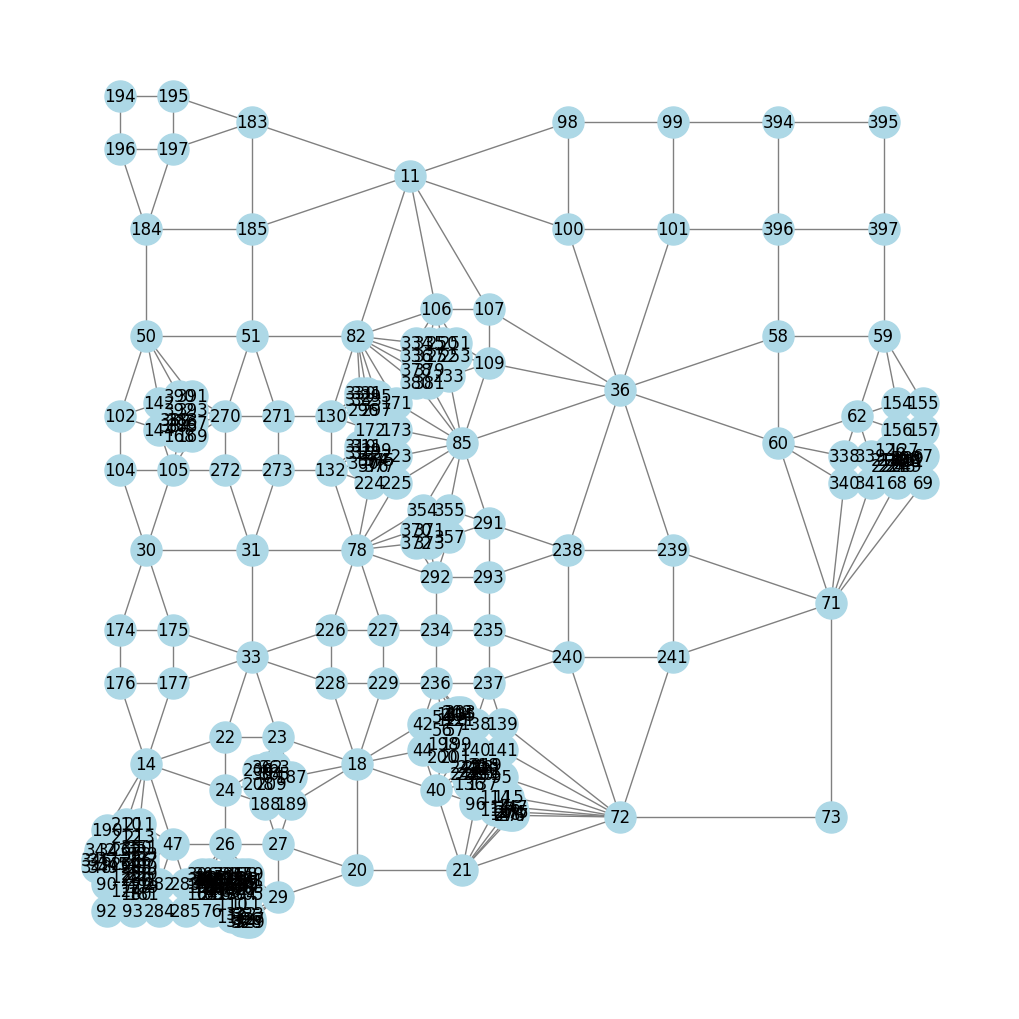

SELECCIONADO 374 con la expansión E04_derecha

SELECCIONADO 357 con la expansión E00

SELECCIONADO 144 con la expansión E00

SELECCIONADO 120 con la expansión E05_arriba_derecha

SELECCIONADO 262 con la expansión E00

SELECCIONADO 386 con la expansión E00

SELECCIONADO 295 con la expansión E01_izquierda

SELECCIONADO 165 con la expansión E04_derecha

SELECCIONADO 184 con la expansión E01_arriba

SELECCIONADO 72 con la expansión E04_derecha

SELECCIONADO 252 con la expansión E04_derecha

SELECCIONADO 396 con la expansión E03_derecha_abajo

SELECCIONADO 206 con la expansión E04_abajo

SELECCIONADO 167 con la expansión E04_arriba

SELECCIONADO 366 con la expansión E00

SELECCIONADO 243 con la expansión E05_abajo_izquierda

SELECCIONADO 246 con la expansión E00

SELECCIONADO 324 con la expansión E00

SELECCIONADO 220 con la expansión E00

SELECCIONADO 255 con la expansión E00
Figura guardada en: Cuadrados\figura_220535618_SpacePart_0.svg


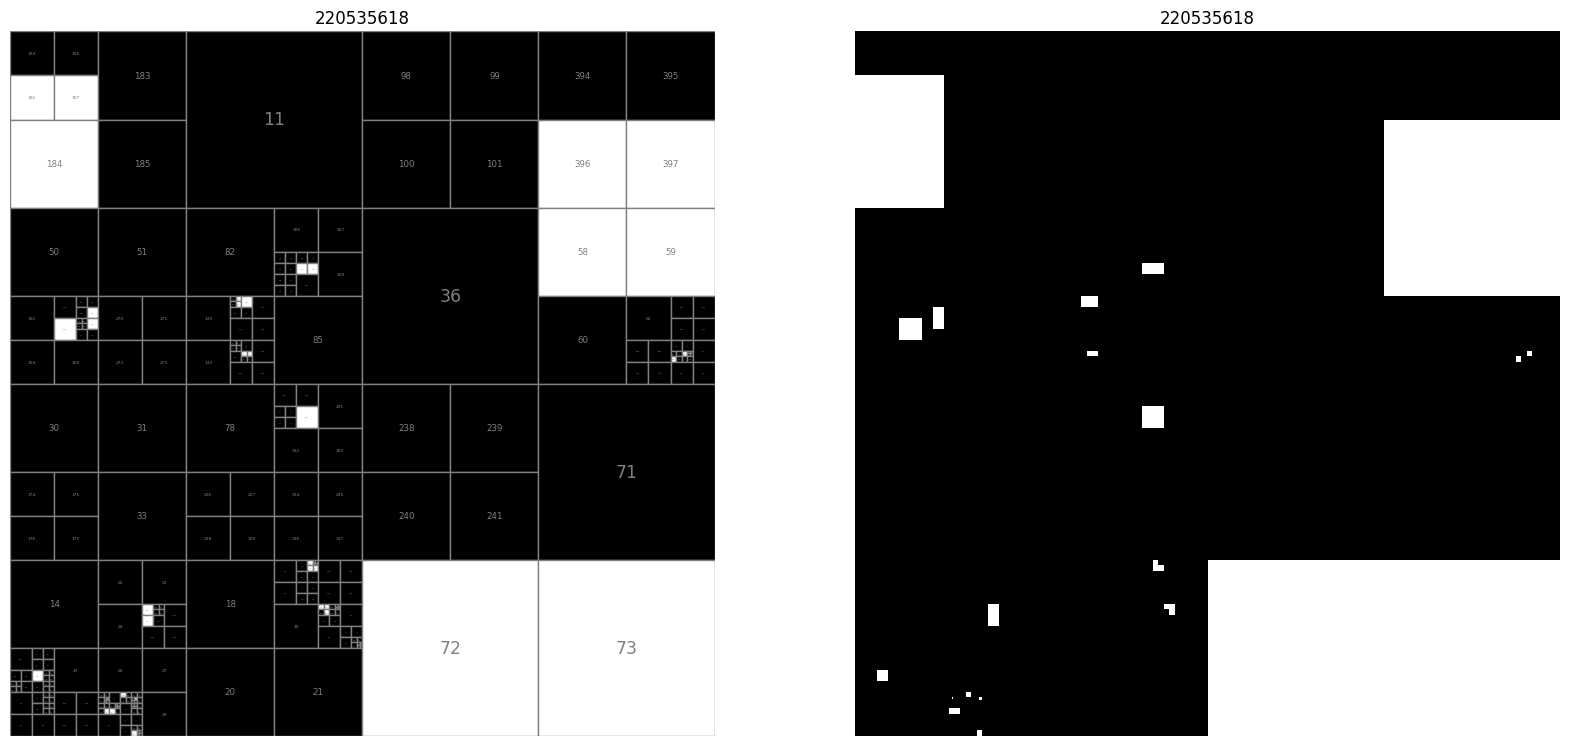

In [65]:
# 'dikjstra', 'clasica'
arquitectura = 'clasica'
npart = 100
prof = 10
nsalas = 20
densidad = 2
guardar = False

cuadrado=crear_mazmorra_space_part(
    arquitectura = arquitectura,
    npart=npart,
    prof_division=prof,
    nsalas=nsalas,
    densidad=densidad,
    guardar=guardar
)

In [57]:
l = hojas_preorden(cuadrado.G)
print(l)

[10, 11, 12, 13, 18, 19, 20, 21, 6, 14, 15, 16, 17, 8, 9, 5]
